In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
np.random.seed(322)
fraud_df = pd.read_csv('/content/drive/MyDrive/creditcard_2023.csv')

In [ ]:
#x = fraud_df.drop(['id','Class'],axis=1).values
y = fraud_df.Class.values
x = fraud_df.iloc[:,1:29].values
#x = fraud_df.iloc[:,12:14].values
z = fraud_df.iloc[:,12:14].values
print(z)

[[ 0.2934381  -0.94138613]
 [ 1.56424577  0.57407401]
 [ 0.65920066  0.80517319]
 ...
 [-0.46184889 -0.60609963]
 [ 0.33521507  0.46417742]
 [-1.1530113   0.48919666]]


In [ ]:
from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x,y,z,test_size=0.9)
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x,y,z,test_size=0.9999)

In [ ]:
from sklearn.preprocessing import StandardScaler
x_train_std = StandardScaler().fit_transform(x_train)
x_test_std = StandardScaler().fit_transform(x_test)
z_train_std = StandardScaler().fit_transform(z_train)
z_test_std = StandardScaler().fit_transform(z_test)

In [ ]:
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components)
x_train_pca = pca.fit_transform(x_train_std)
x_test_pca = pca.fit_transform(x_test_std)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 9, metric = 'chebyshev', n_jobs=-1)
classifier.fit(x_train_pca,y_train)
y_pred = classifier.predict(x_test_pca)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [5, 7, 9],
    'metric': ['minkowski', 'manhattan', 'euclidean', 'chebyshev']
}

knn = KNeighborsClassifier(n_jobs=-1)

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(x_train_pca, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best accuracy:", best_score)

Best parameters: {'metric': 'chebyshev', 'n_neighbors': 9}
Best accuracy: 0.9372702204674239


In [ ]:
import pandas as pd
pd.options.mode.copy_on_write = True
results_df = pd.DataFrame(grid_search.cv_results_)

results_df = results_df[['param_n_neighbors', 'param_metric', 'mean_test_score', 'std_test_score']]

results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)

print(results_df)

   param_n_neighbors param_metric  mean_test_score  std_test_score
11                 9    chebyshev         0.937270        0.001830
5                  9    manhattan         0.937200        0.002173
2                  9    minkowski         0.937182        0.001653
8                  9    euclidean         0.937182        0.001653
4                  7    manhattan         0.936971        0.002049
1                  7    minkowski         0.936760        0.001856
7                  7    euclidean         0.936760        0.001856
10                 7    chebyshev         0.936461        0.002402
0                  5    minkowski         0.935019        0.002243
6                  5    euclidean         0.935019        0.002243
3                  5    manhattan         0.934509        0.002831
9                  5    chebyshev         0.934281        0.002418


Наилучшая аккуратность была получена с метрикой Чейбышева и 9 соседями, но видно что аккуратность мало зависит от метрики и больше зависит от количества соседей. С меньшим числом соседей метрика Чейбышева показывает себя хуже всех.

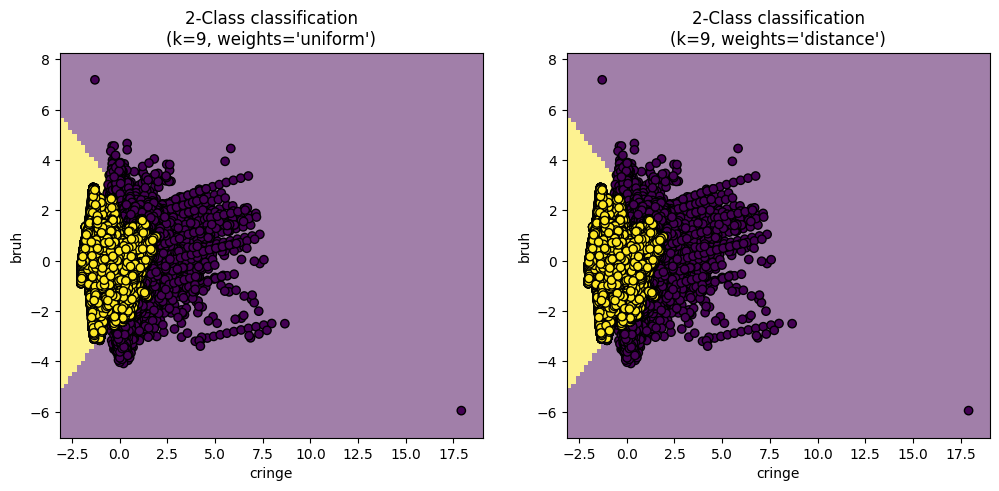

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay

classifier = KNeighborsClassifier(n_neighbors=9, metric='chebyshev')

classifier.fit(z_train_std, y_train)

titles = [f"2-Class classification\n(k={classifier.n_neighbors}, weights={weights!r})" for weights in ("uniform", "distance")]

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    disp = DecisionBoundaryDisplay.from_estimator(
        classifier,
        z_test_std,
        xlabel='cringe',
        ylabel='bruh',
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(z[:, 0], z[:, 1], c=y, edgecolors="k")
    _ = disp.ax_.set_title(titles.pop(0))
#    ax.set_xlim(-3,3)
#    ax.set_ylim(-3,3)

plt.show()